In [128]:
!pip install pandas numpy torchvision 

In [129]:
%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import pandas as pd
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
# import numpy as np
# import os 
import torch.optim.lr_scheduler as lr_scheduler
# from PIL import Image
# from torchvision import transforms
# import cv2
# from generate_datasetHM import HeatmapDataset
from generate_dataset import CustomDataset
import matplotlib.pyplot as plt
from CNNs.models import CNN2,CNN1
from CNNs.modelsLSTM import CNN_FE

from CNNs.Baseline import LinearReg
from analysis import plot_circles_on_image,pixel_distance,Metrics,epoch_metrics,error_calc
import copy


# Train models to find the center of Mass of a celectial object
## Objects:
- Mars
- Asteroids
## Models:
- Plain CNN (CNN2)
- ResNet (CNN1)  

In [130]:
# Load the datasets
train_dataset = torch.load('train_dataset.pth')
val_dataset= torch.load('val_dataset.pth')
test_dataset = torch.load('test_dataset.pth')

In [131]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader =   DataLoader(val_dataset, batch_size=20, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True)

In [132]:
len(train_dataset)
len(val_dataset)

21797

In [133]:
def plot_results(num_epochs, train_losses, val_losses, val_distances):
   epochs = range(1, num_epochs + 1)
   # Plotting all the losses
   plt.figure(figsize=(12, 6))

   plt.scatter(epochs, train_losses, label='Training Loss')
   plt.scatter(epochs, val_losses, label='Validation Loss', color='orange')
   plt.xlabel('Epochs')
   plt.ylabel('Loss')
   plt.legend()
   plt.title('Loss')
   plt.tight_layout()
   plt.show()

   # Plotting all the distances
   plt.figure(figsize=(12, 6))

   plt.scatter(epochs, val_distances, label='Validation Distance', color='green')
   plt.xlabel('Epochs')
   plt.ylabel('Distance')
   plt.legend()
   plt.title('Pixel Distance')
   plt.tight_layout()
   plt.show()


def plot_metrics(num_epochs, metrics):
    epochs = range(1, num_epochs + 1)
    
    # Create a figure with a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    for i, (metric, values) in enumerate(metrics.items()):
        axes[i].plot(epochs, values, label=metric)
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel('Value')
        axes[i].set_title(f'{metric} over Epochs')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

In [134]:
def calculate_accuracy(outputs, targets):
    total_distance = 0
    for output, target in zip(outputs, targets):
        distance = ((target[0] - output[0]) ** 2 + (target[1] - output[1]) ** 2) ** 0.5
        total_distance += distance
    return total_distance / len(outputs)

In [135]:
def train(valloader,dataloader,model,device='cpu'):
    # Instantiate the model
    # Define an optimizer and loss function
    model.to(device)
    # optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9) 
    optimizer = optim.Adam(model.parameters(), lr=0.001) 

    criterion = nn.MSELoss()
    # criterion = nn.SmoothL1Loss()

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

    patience = 10  # Number of epochs to wait for improvement before stopping
    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    no_improvement_counter = 0

    train_losses = []
    val_losses = []
    val_distances = []
    accuracies = []
    metrics_history = {'MAE': [], 'MSE': [], 'RMSE': [], 'R-squared': []}

    num_epochs = 80  # Set the number of epochs as required
    for epoch in range(num_epochs):
        print("##### epoch {} : #####".format(epoch+1))

        model.train()  # Set the model to training mode
        running_loss,tot = 0.0,0.0
        b=0.

        for inputs, targets in dataloader:
            tot += dataloader.batch_size  
            inputs=inputs.to(device)
            targets=targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss+= loss.item()
            b += 1.0
            if  b % 500 == 0:
                print("batch: {}: Running Loss  {:.4f}".format(b,running_loss/b))
            
        train_loss = running_loss / (len(dataloader))
        train_losses.append(train_loss)

        model.eval()
        
        validation_loss = 0.0
        total_distance = 0.0
        counter=0.0
        Error=0.0
        metrics = {'MAE': 0.0, 'MSE': 0.0, 'RMSE': 0.0, 'R-squared': 0.0,'count': 0}

        n=0.0
        with torch.no_grad():
            for x, y in valloader:
                x_val, y_val = x.to(device), y.to(device)
                val_result = model(x_val)
                lossv = criterion(val_result, y_val)
                validation_loss += lossv.item()
                d, c = pixel_distance(val_result, y_val)
                Error+= error_calc(val_result, y_val)
                total_distance += d.item()
                counter += c
                Metrics(metrics, val_result, y_val)
                # if c/(valloader.batch_size)>= 0.5:
                #     plot_circles_on_image(x_val[c], val_result[c], y_val[c])
                # n+=1.0                 

        avg_val_loss = validation_loss / len(valloader)
        avg_val_distance = total_distance / len(valloader)
        accuracy = 100 * (counter / len(valloader.dataset))
        Error/=len(valloader)
        val_losses.append(avg_val_loss)
        val_distances.append(avg_val_distance)
        accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}\n" 
              f"Validation Distance: {avg_val_distance:.4f}, Validation Accuracy: {accuracy:.4f}, Error: {Error:.4f} ")
        epoch_metric = epoch_metrics(metrics)
        for metric, value in epoch_metric.items():
            metrics_history[metric].append(value)
        # Step the learning rate scheduler
        scheduler.step(avg_val_loss)

        # Early stopping and saving the best model
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            if no_improvement_counter >= patience:
                print("Early stopping triggered")
                num_epochs=epoch+1
                break

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    plot_results(num_epochs,train_losses,val_losses,val_distances)
    # plot_metrics(num_epochs,metrics_history)
    return model, train_losses ,val_losses ,val_distances,metrics_history 


In [140]:
def Test(model, testloader, device='cpu'):
    model.to(device)
    model.eval()
    num_epochs = 5 
    # criterion = nn.MSELoss()
    criterion = nn.SmoothL1Loss()
    test_losses = []
    test_distances = []
    accuracies = []
    # metrics_history = {'MAE': [], 'MSE': [], 'RMSE': [], 'R-squared': []}
    Error=0.0
 # Set the number of epochs as required
    for epoch in range(num_epochs):
        print("##### epoch {} : #####".format(epoch+1))
        metrics = {'MAE': 0.0, 'MSE': 0.0, 'RMSE': 0.0, 'R-squared': 0.0, 'count': 0}
        
        test_loss = 0.0
        total_distance = 0.0
        counter = 0.0
        n=0.0
        with torch.no_grad():
            for x, y in testloader:
                x_test, y_test = x.to(device), y.to(device)
                test_result = model(x_test)
                losst = criterion(test_result, y_test)
                test_loss += losst.item()
                d, c = pixel_distance(test_result, y_test)
                total_distance += d
                counter += c
                Metrics(metrics, test_result, y_test)
                if n%500==0 and c/(testloader.batch_size)>= 0.95:
                    plot_circles_on_image(x_test[0], test_result[0], y_test[0])
                n+=1.0  

                Error+= error_calc(test_result, y_test)
                counter += c              

        Error/=len(testloader)
        avg_test_loss = test_loss / len(testloader)
        avg_test_distance = total_distance / len(testloader)
        accuracy = 100 * (counter / len(testloader.dataset))
        test_losses.append(avg_test_loss)
        test_distances.append(avg_test_distance)
        accuracies.append(accuracy)
        print(f"Test Loss: {avg_test_loss:.4f}, Test Distance: {avg_test_distance:.4f}, Error: {Error:.4f} ")
        epoch_metric = epoch_metrics(metrics)
        # for metric, value in epoch_metric.items():
        #     metrics_history[metric].append(value)
            
    # return test_losses,test_distances,metrics_history

In [137]:
# # Load your pretrained model
# CoM_model = torch.load('model_CNN2_CoB.pth')

# # # Freeze all layers except the last fully connected layer
# for name, param in CoM_model.named_parameters():
#     if 'fc' not in name:  # Change 'fc2' to the name of your last fully connected layer
#         param.requires_grad = False

# Freeze all layers
# for param in model.parameters():
#     param.requires_grad = False

# Modify the final layer
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 2)  # Assuming CoM has 2 coordinates (x, y)


** GPU **
##### epoch 1 : #####
batch: 500.0: Running Loss  286.8815
batch: 1000.0: Running Loss  168.1310
batch: 1500.0: Running Loss  188.0238
batch: 2000.0: Running Loss  147.2054
Epoch 1/80, Training Loss: 145.8245, Validation Loss: 11.7916
Validation Distance: 3.3971, Validation Accuracy: 97.1647, Error: 1.9038 
##Metrics##:
MAE : 2.205711603164673
MSE : 11.792208671569824
RMSE : 1.6005127429962158
R-squared : -8143420.0
Count: 43594
##### epoch 2 : #####
batch: 500.0: Running Loss  19.7806
batch: 1000.0: Running Loss  30.7261
batch: 1500.0: Running Loss  31.6308
batch: 2000.0: Running Loss  76.3241
Epoch 2/80, Training Loss: 75.4605, Validation Loss: 12.6877
Validation Distance: 3.9281, Validation Accuracy: 91.8980, Error: 2.2820 
##Metrics##:
MAE : 2.5294623374938965
MSE : 12.68796443939209
RMSE : 1.7016040086746216
R-squared : -9674670.0
Count: 43594
##### epoch 3 : #####
batch: 500.0: Running Loss  19.0650
batch: 1000.0: Running Loss  18.7787
batch: 1500.0: Running Loss  20.27

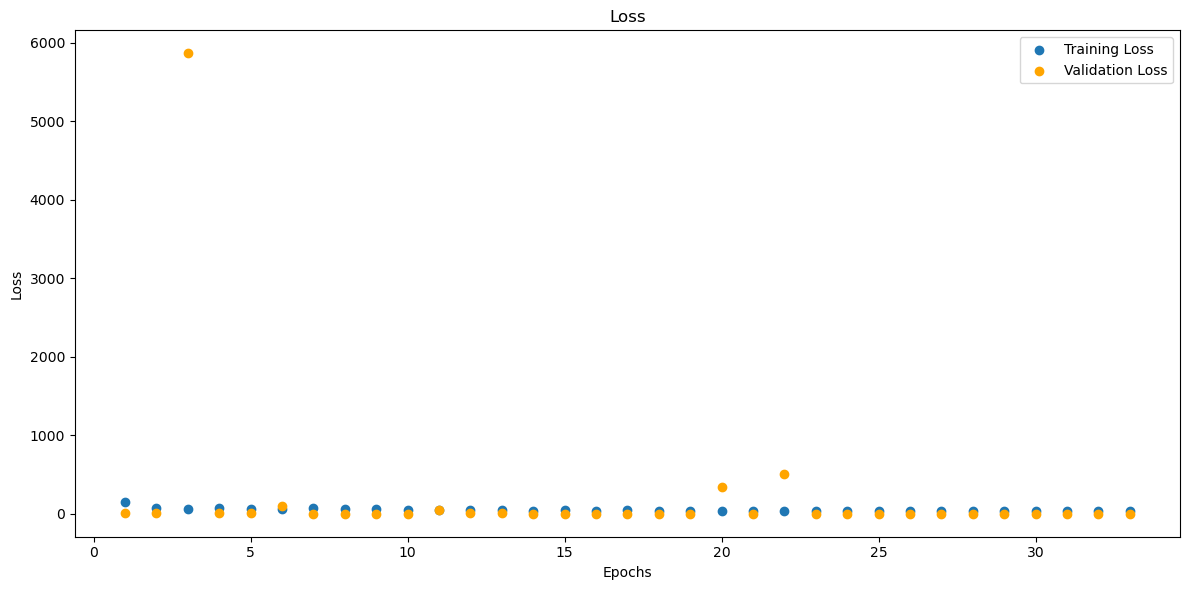

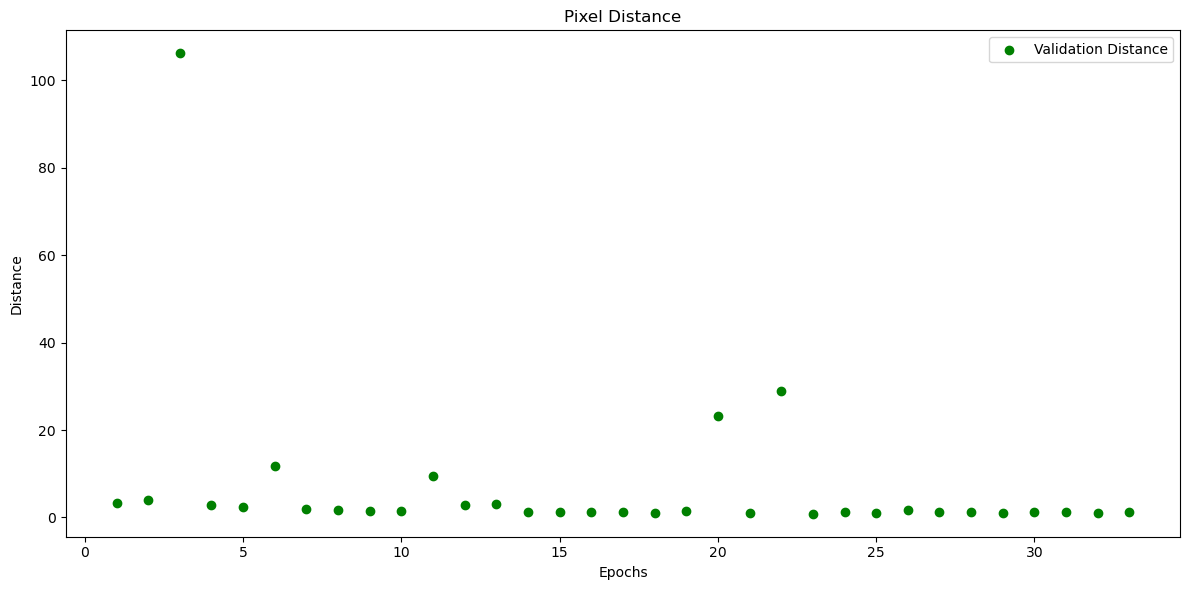

In [139]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("** GPU **")
else:
    device = torch.device("cpu")
    print("** CPU **")

CoM_model=CNN1()
model,train_losses ,val_losses ,val_distances,val_metrics =train(val_loader,train_loader,CoM_model,device)


In [ ]:
# torch.save(model, 'model_CNN2_COB_COMM.pth')
# print("Model paths is saved")

Model paths is saved


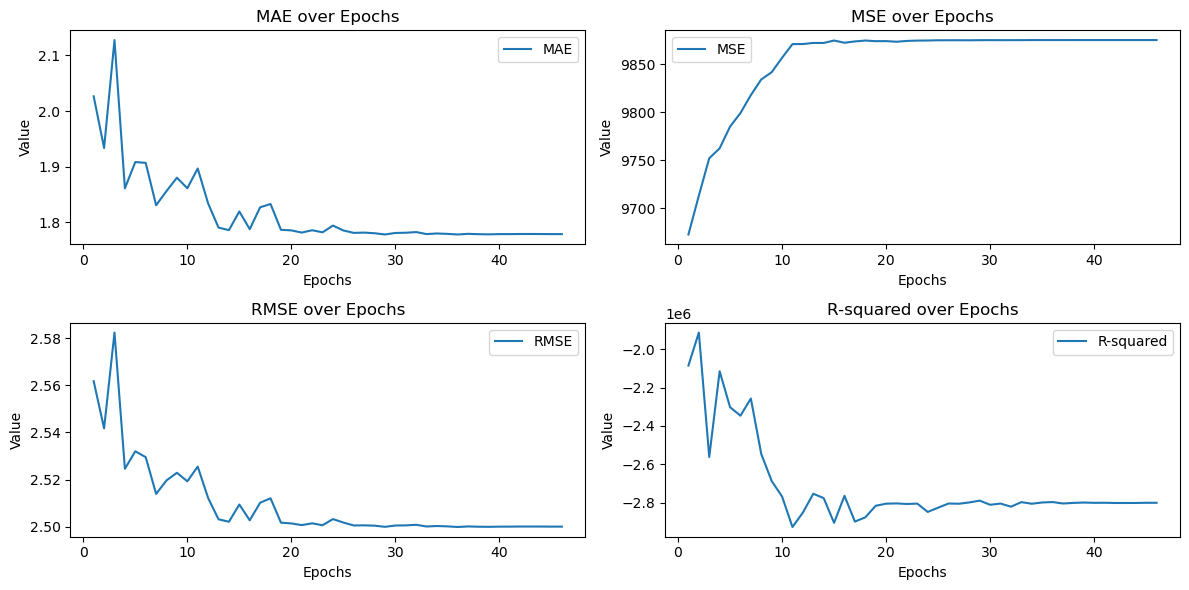

In [ ]:
# type(val_metrics)
plot_metrics(46,val_metrics)


In [143]:
test_model= torch.load('model_CNN2_CoM.pth')

##### epoch 1 : #####


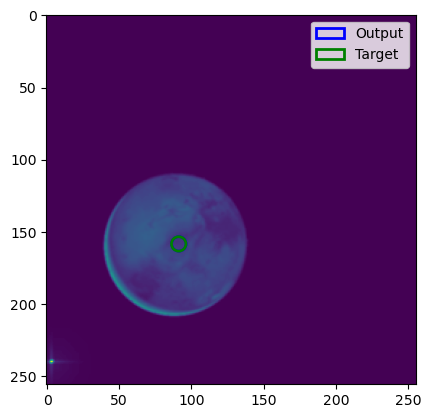

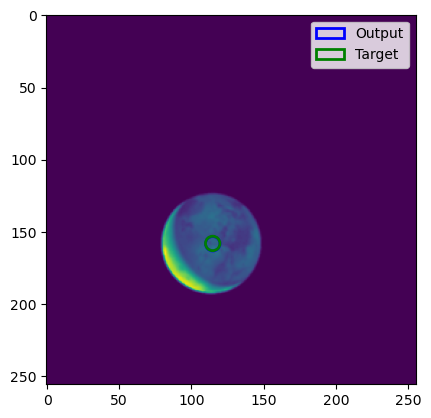

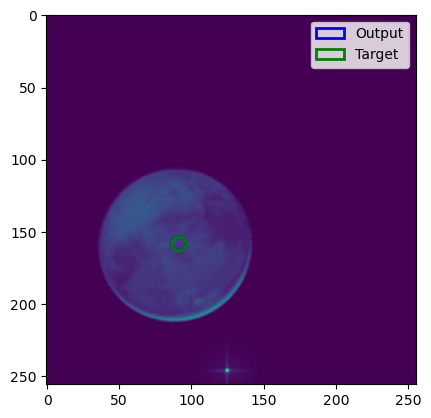

Test Loss: 0.1592, Test Distance: 0.4339, Error: 0.2315 
##Metrics##:
MAE : 0.2597890794277191
MSE : 38.05025863647461
RMSE : 0.9742754101753235
R-squared : 0.9892405271530151
Count: 42768
##### epoch 2 : #####


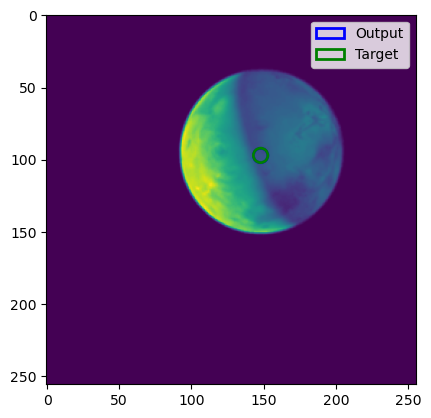

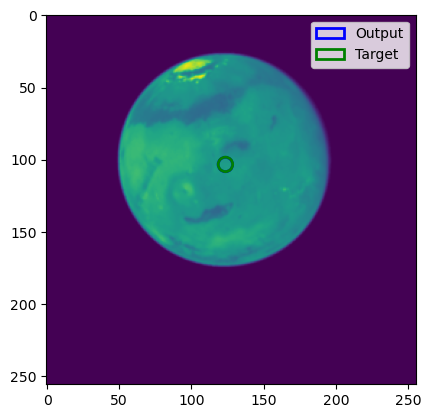

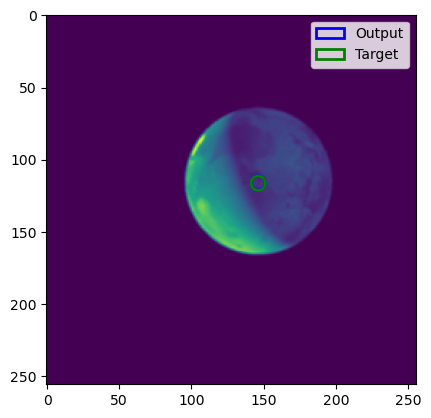

Test Loss: 0.1592, Test Distance: 0.4339, Error: 0.2320 
##Metrics##:
MAE : 0.2597894072532654
MSE : 38.05022430419922
RMSE : 0.9738641977310181
R-squared : 0.9891653060913086
Count: 42768
##### epoch 3 : #####


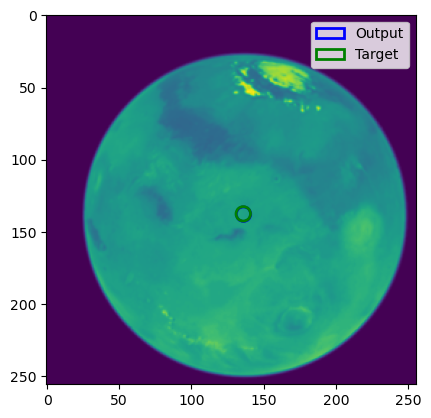

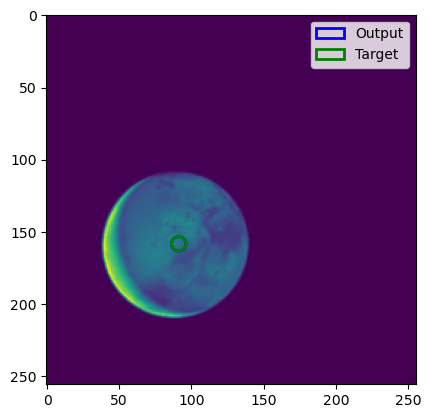

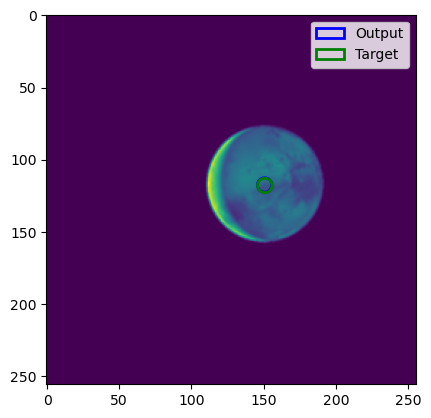

Test Loss: 0.1592, Test Distance: 0.4340, Error: 0.2325 
##Metrics##:
MAE : 0.2597891092300415
MSE : 38.050254821777344
RMSE : 0.97696453332901
R-squared : 0.9891212582588196
Count: 42768
##### epoch 4 : #####


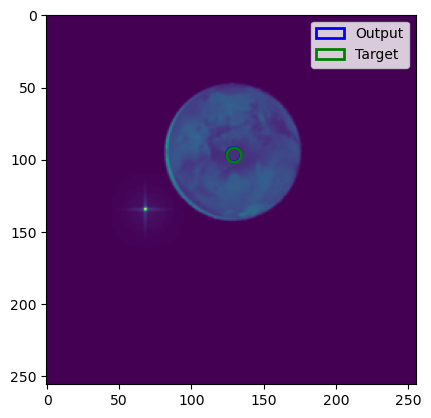

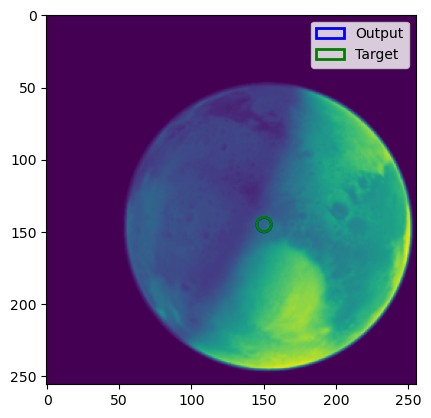

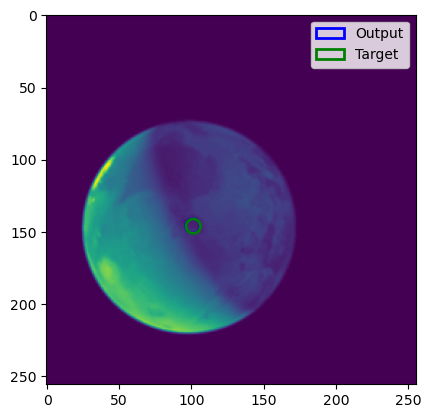

Test Loss: 0.1592, Test Distance: 0.4339, Error: 0.2332 
##Metrics##:
MAE : 0.25978901982307434
MSE : 38.050254821777344
RMSE : 0.9760048389434814
R-squared : 0.9891963601112366
Count: 42768
##### epoch 5 : #####


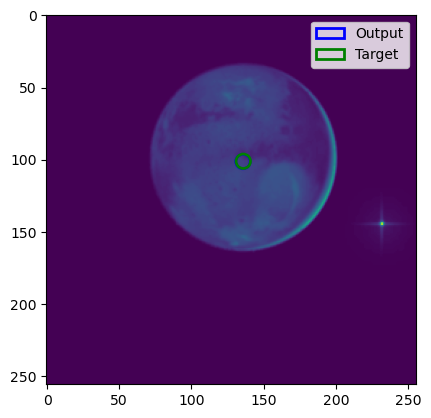

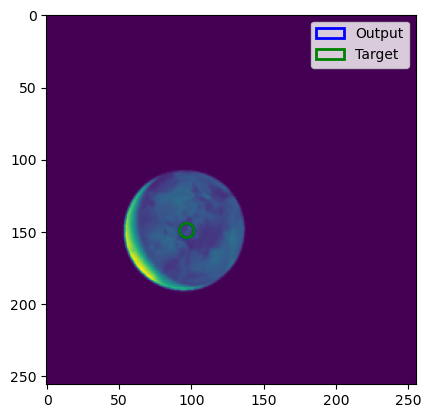

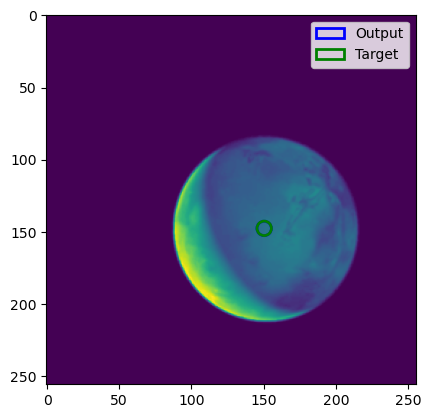

Test Loss: 0.1592, Test Distance: 0.4339, Error: 0.2332 
##Metrics##:
MAE : 0.2597893178462982
MSE : 38.05024337768555
RMSE : 0.9753347635269165
R-squared : 0.9891682863235474
Count: 42768


In [144]:
Test(test_model, test_loader, device='cpu')

In [ ]:
# testmodel=torch.load('model_CNN1_CoB.pth', map_location=torch.device('cpu'))

##### epoch 1 : #####


c:\Users\bushra.aldhanhani\Documents\UCL\project\UCL_project\generate_dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32)


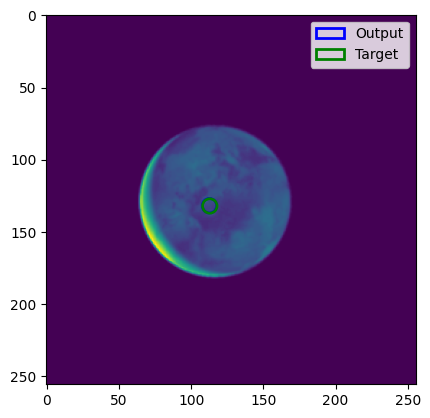

KeyboardInterrupt: 

In [ ]:
# test_losses,test_distances,test_metrics=Test(testmodel, test_loader, device='cpu')